In [28]:
import sys, os, json
sys.path.append(os.path.abspath("./../../feedback-grape"))
sys.path.append(os.path.abspath("./../../"))
sys.path.append(os.path.abspath("./../"))
from feedback_grape.utils.fidelity import fidelity

import jax
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [29]:
# open all .json files from ./eval
dir_ = "./eval"
json_files = [f for f in os.listdir(dir_) if f.endswith(".json")]
data = []

fidelity_vmap = jax.vmap(jax.jit(lambda rho_i, rho_t: fidelity(C_target=rho_i, U_final=rho_t, evo_type="unitary")))
print("Opening files...")
for file in tqdm(json_files):
    with open(os.path.join(dir_, file), 'r') as f:
        content = json.load(f)
        content["filename"] = file

        # Compute fidelities because they were not stored in this run
        rho_each_timestep = [np.array(rho_real) + 1j * np.array(rho_imag)
                             for rho_real, rho_imag in zip(content["state_each_timestep_real"],
                                                          content["state_each_timestep_imag"])]
        rho_initial = rho_each_timestep[0]
        fidelity_each_timestep = np.array([fidelity_vmap(rho_initial, rho_timestep) for rho_timestep in rho_each_timestep])
        content["fidelity_each_timestep"] = fidelity_each_timestep
        
        # Remove large data to save memory
        del content["state_each_timestep_real"]
        del content["state_each_timestep_imag"]
        data.append(content)
print("Done.")

print([key for key in data[0].keys()])  # Print keys of the first JSON file to see available data

Opening files...


100%|██████████| 450/450 [01:08<00:00,  6.57it/s]

Done.
['iterations', 'returned_params', 'final_fidelity', 'final_purity', 'optimized_trainable_parameters', 'filename', 'fidelity_each_timestep']


In [30]:
longest = max([len(d["fidelity_each_timestep"]) for d in data])
fidelities_mat = np.zeros((len(data), longest))

for i, d in enumerate(data):
    fidelities = d["fidelity_each_timestep"]
    fidelities_mat[i, :len(fidelities)] = fidelities.mean(axis=1)

#baseline = np.load("./baseline.npz")["fidelities"]
#fidelities_mat = np.vstack([fidelities_mat, baseline])

Text(0.5, 1.0, 'Fidelity over Time Steps for All Runs')

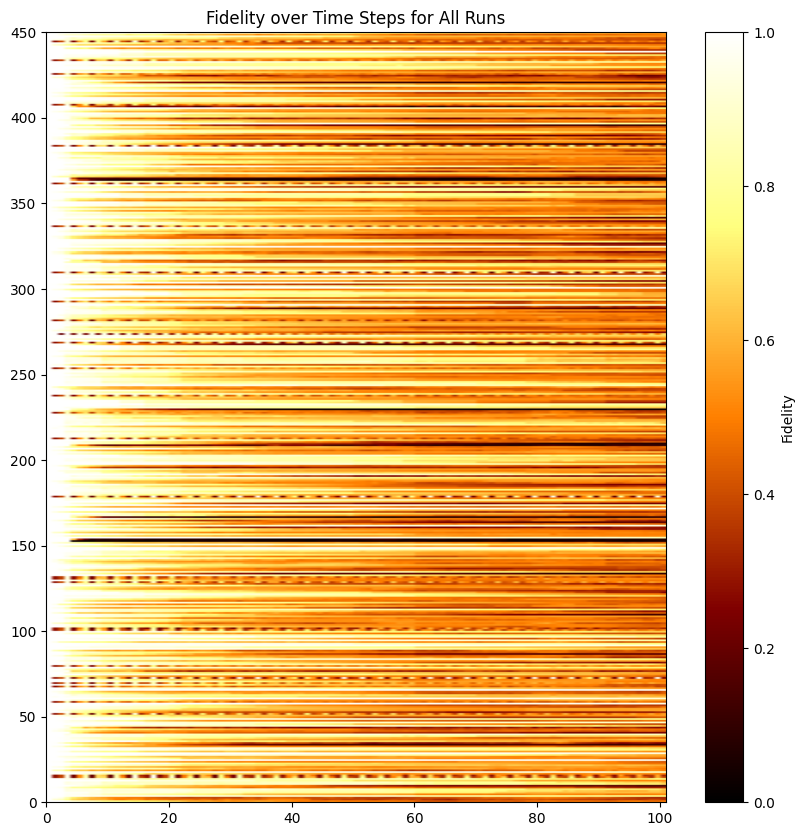

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(
    fidelities_mat, aspect='auto', origin='lower', 
    extent=[0, longest, 0, len(data)],
    vmin=0, vmax=1,
    cmap='afmhot'
)
fig.colorbar(im, ax=ax, label="Fidelity")
ax.set_title("Fidelity over Time Steps for All Runs")

In [34]:
# Group data by all but the sample "s" in filename. From each group, select the one with highest average fidelity
best_data = {}
for d in data:
    key = d["filename"].rsplit("_s", 1)[0]  # Remove sample part
    fidelities = d["fidelity_each_timestep"]
    avg_fidelity = np.mean(fidelities, axis=(0, 1))
    if key not in best_data or avg_fidelity > best_data[key][1]:
        best_data[key] = (fidelities, avg_fidelity)

fidelities_best_mat = np.zeros((len(best_data), longest))
for i, v in enumerate(best_data.values()):
    fidelities = v[0]
    fidelities_best_mat[i, :len(fidelities)] = fidelities.mean(axis=1)

print(f"Selected {len(best_data)} best runs out of {len(data)} total runs.")

Selected 90 best runs out of 450 total runs.


Text(0.5, 1.0, 'Fidelity over Time Steps for Best Runs out of Each Group')

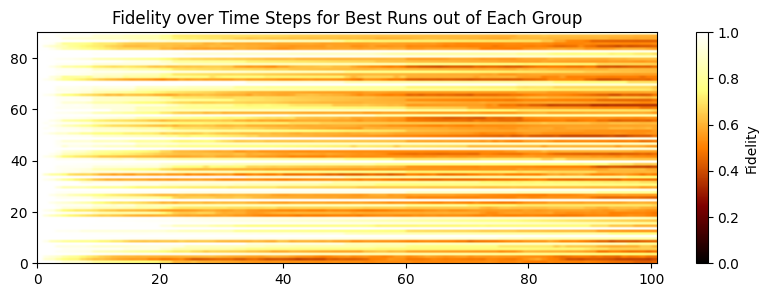

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
im = ax.imshow(
    fidelities_best_mat, aspect='auto', origin='lower', 
    extent=[0, longest, 0, len(best_data)],
    vmin=0, vmax=1,
    cmap='afmhot'
)
fig.colorbar(im, ax=ax, label="Fidelity")
ax.set_title("Fidelity over Time Steps for Best Sample out of Each Group")

In [58]:
# Group best_data by gamma_p and gamma_m and plot average fidelity in 2d heatmap
gamma_groups = {}
for key, v in best_data.items():
    parts = key.split("_")
    gamma_p = None
    gamma_m = None
    for part in parts:
        if part.startswith("gammap"):
            gamma_p = float(part.split("gammap")[1][1:])
        elif part.startswith("gammam"):
            gamma_m = float(part.split("gammam")[1][1:])
    if gamma_p <= 1e-6: continue  # Skip gamma_p = 0.0
    if gamma_p is not None and gamma_m is not None:
        group_key = (gamma_p, gamma_m)
        if group_key not in gamma_groups:
            gamma_groups[group_key] = []
        gamma_groups[group_key].append(v[0])  # Append fidelities

gamma_p_values = sorted(set(k[0] for k in gamma_groups.keys()))
gamma_m_values = sorted(set(k[1] for k in gamma_groups.keys()))
fidelity_grid = np.zeros((len(gamma_p_values), len(gamma_m_values)))
for i, gp in enumerate(gamma_p_values):
    for j, gm in enumerate(gamma_m_values):
        group_key = (gp, gm)
        if group_key in gamma_groups:
            fidelities_list = gamma_groups[group_key]
            avg_fidelity = np.mean([fidelities.mean() for fidelities in fidelities_list])
            fidelity_grid[i, j] = avg_fidelity
        else:
            fidelity_grid[i, j] = 0  # No data

print(gamma_m_values, gamma_p_values)

[0.001, 0.0017782794100389228, 0.0031622776601683794, 0.005623413251903491, 0.01, 0.01778279410038923, 0.03162277660168379, 0.05623413251903491, 0.1] [0.0001, 0.0001333521432163324, 0.00014330125702369627, 0.0001539926526059492, 0.00016548170999431815, 0.00017782794100389227, 0.00019109529749704405, 0.0002053525026457146, 0.00022067340690845897, 0.00023713737056616554, 0.0002738419634264361, 0.00029427271762092817, 0.00031622776601683794, 0.0003651741272548377, 0.00042169650342858224, 0.0004531583637600818, 0.0004869675251658631, 0.0005623413251903491, 0.0006042963902381329, 0.0006978305848598664, 0.0007498942093324559, 0.0008659643233600654, 0.001, 0.0010746078283213176, 0.0012409377607517195, 0.001333521432163324, 0.0017782794100389228, 0.002053525026457146, 0.0023713737056616554, 0.0025482967479793467, 0.0031622776601683794, 0.003398208328942559, 0.003651741272548377, 0.004869675251658631, 0.005232991146814947, 0.005623413251903491, 0.007498942093324558, 0.00930572040929699, 0.01, 0

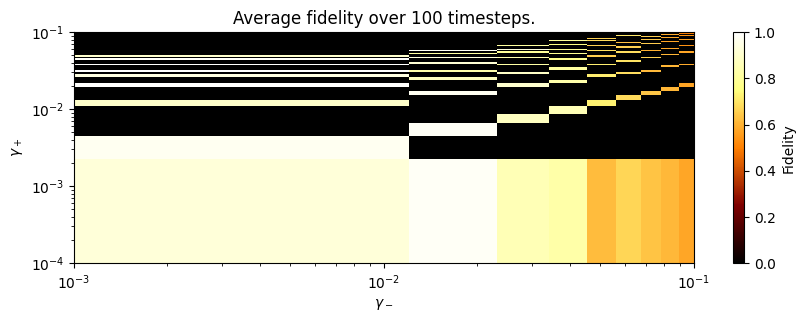

In [59]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.set_xlabel("$\\gamma_-$")
ax.set_ylabel("$\\gamma_+$")
ax.set_title(f"Average fidelity over {fidelities_mat.shape[1]-1} timesteps.")

im = ax.imshow(
    fidelity_grid, aspect='auto', origin='lower', 
    extent=[min(gamma_m_values), max(gamma_m_values), min(gamma_p_values), max(gamma_p_values)],
    vmin=0, vmax=1,
    cmap='afmhot'
)
ax.set_yscale('log')
ax.set_xscale('log')

fig.colorbar(im, ax=ax, label="Fidelity")